In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [4]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


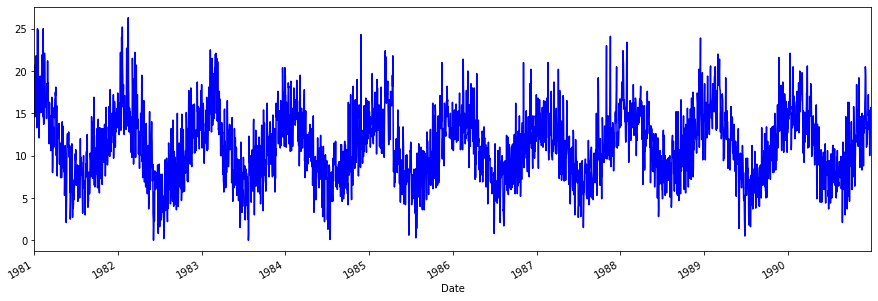

In [5]:
df.Temp.plot(figsize=(15, 5), color ="b")

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [8]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.lstm(x, hidden)
        x = self.fc(x)
        return x, hidden

In [35]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0
})

# Training Preparation -> MCOC

In [36]:
model = LSTM(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/lstm")

# Training

In [37]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset,dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode =="test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 131.4075 | Test_cost  = 118.0226 | 




Epoch     2
Train_cost  = 89.1871 | Test_cost  = 68.0559 | 




Epoch     3
Train_cost  = 51.7988 | Test_cost  = 43.5494 | 




Epoch     4
Train_cost  = 34.8234 | Test_cost  = 31.9559 | 




Epoch     5
Train_cost  = 26.5456 | Test_cost  = 25.5820 | 




Epoch     6
Train_cost  = 22.0455 | Test_cost  = 21.9099 | 




Epoch     7
Train_cost  = 19.6212 | Test_cost  = 19.8968 | 




Epoch     8
Train_cost  = 18.4224 | Test_cost  = 18.8663 | 




Epoch     9
Train_cost  = 17.8675 | Test_cost  = 18.3490 | 




Epoch    10
Train_cost  = 17.5899 | Test_cost  = 18.0732 | 




Epoch    11
Train_cost  = 17.4122 | Test_cost  = 17.9145 | 




Epoch    12
Train_cost  = 17.2769 | Test_cost  = 17.8236 | 




Epoch    13
Train_cost  = 17.1744 | Test_cost  = 17.7756 | 




Epoch    14
Train_cost  = 17.1017 | Test_cost  = 17.7506 | 




Epoch    15
Train_cost  = 17.0518 | Test_cost  = 17.7329 | 




Epoch    16
Train_cost  = 17.0161 | Test_cost  = 17.7138 | 




Epoch    17
Train_cost  = 16.9881 | Test_cost  = 17.6911 | 




Epoch    18
Train_cost  = 16.9645 | Test_cost  = 17.6663 | 




Epoch    19
Train_cost  = 16.9442 | Test_cost  = 17.6422 | 




Epoch    20
Train_cost  = 16.9268 | Test_cost  = 17.6208 | 


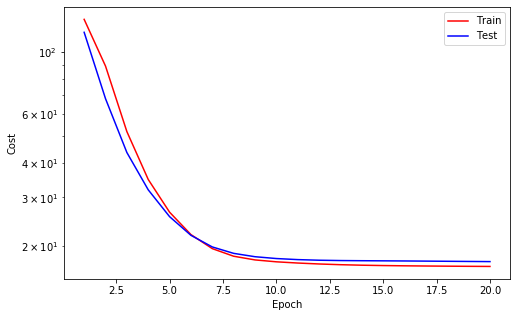



Epoch    21
Train_cost  = 16.9119 | Test_cost  = 17.6031 | 




Epoch    22
Train_cost  = 16.8993 | Test_cost  = 17.5890 | 




Epoch    23
Train_cost  = 16.8885 | Test_cost  = 17.5777 | 




Epoch    24
Train_cost  = 16.8792 | Test_cost  = 17.5687 | 




Epoch    25
Train_cost  = 16.8711 | Test_cost  = 17.5610 | 




Epoch    26
Train_cost  = 16.8639 | Test_cost  = 17.5541 | 




Epoch    27
Train_cost  = 16.8574 | Test_cost  = 17.5477 | 




Epoch    28
Train_cost  = 16.8514 | Test_cost  = 17.5415 | 




Epoch    29
Train_cost  = 16.8456 | Test_cost  = 17.5351 | 




Epoch    30
Train_cost  = 16.8398 | Test_cost  = 17.5279 | 




Epoch    31
Train_cost  = 16.8335 | Test_cost  = 17.5204 | 




Epoch    32
Train_cost  = 16.8265 | Test_cost  = 17.5127 | 




Epoch    33
Train_cost  = 16.8189 | Test_cost  = 17.5048 | 




Epoch    34
Train_cost  = 16.8111 | Test_cost  = 17.4968 | 




Epoch    35
Train_cost  = 16.8033 | Test_cost  = 17.4889 | 




Epoch    36
Train_cost  = 16.7956 | Test_cost  = 17.4814 | 




Epoch    37
Train_cost  = 16.7883 | Test_cost  = 17.4742 | 




Epoch    38
Train_cost  = 16.7812 | Test_cost  = 17.4674 | 




Epoch    39
Train_cost  = 16.7745 | Test_cost  = 17.4610 | 




Epoch    40
Train_cost  = 16.7681 | Test_cost  = 17.4550 | 


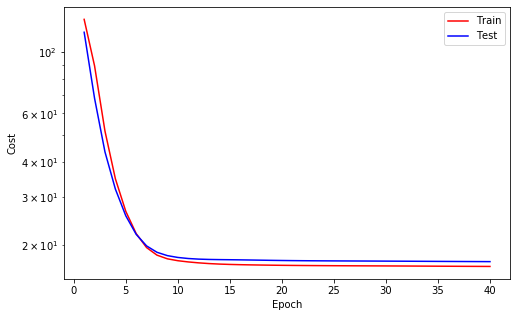



Epoch    41
Train_cost  = 16.7620 | Test_cost  = 17.4493 | 




Epoch    42
Train_cost  = 16.7560 | Test_cost  = 17.4438 | 




Epoch    43
Train_cost  = 16.7502 | Test_cost  = 17.4387 | 




Epoch    44
Train_cost  = 16.7446 | Test_cost  = 17.4339 | 




Epoch    45
Train_cost  = 16.7392 | Test_cost  = 17.4293 | 




Epoch    46
Train_cost  = 16.7337 | Test_cost  = 17.4251 | 




Epoch    47
Train_cost  = 16.7279 | Test_cost  = 17.4206 | 




Epoch    48
Train_cost  = 16.7222 | Test_cost  = 17.4153 | 




Epoch    49
Train_cost  = 16.7169 | Test_cost  = 17.4097 | 




Epoch    50
Train_cost  = 16.7116 | Test_cost  = 17.4046 | 




Epoch    51
Train_cost  = 16.7064 | Test_cost  = 17.4002 | 




Epoch    52
Train_cost  = 16.7014 | Test_cost  = 17.3963 | 




Epoch    53
Train_cost  = 16.6965 | Test_cost  = 17.3928 | 




Epoch    54
Train_cost  = 16.6916 | Test_cost  = 17.3894 | 




Epoch    55
Train_cost  = 16.6868 | Test_cost  = 17.3859 | 




Epoch    56
Train_cost  = 16.6820 | Test_cost  = 17.3825 | 




Epoch    57
Train_cost  = 16.6771 | Test_cost  = 17.3792 | 




Epoch    58
Train_cost  = 16.6723 | Test_cost  = 17.3760 | 




Epoch    59
Train_cost  = 16.6675 | Test_cost  = 17.3730 | 




Epoch    60
Train_cost  = 16.6625 | Test_cost  = 17.3702 | 


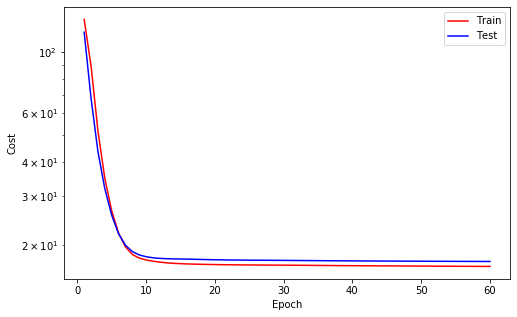



Epoch    61
Train_cost  = 16.6573 | Test_cost  = 17.3669 | 




Epoch    62
Train_cost  = 16.6521 | Test_cost  = 17.3630 | 




Epoch    63
Train_cost  = 16.6471 | Test_cost  = 17.3591 | 




Epoch    64
Train_cost  = 16.6421 | Test_cost  = 17.3557 | 




Epoch    65
Train_cost  = 16.6371 | Test_cost  = 17.3528 | 




Epoch    66
Train_cost  = 16.6323 | Test_cost  = 17.3504 | 




Epoch    67
Train_cost  = 16.6274 | Test_cost  = 17.3482 | 




Epoch    68
Train_cost  = 16.6226 | Test_cost  = 17.3461 | 




Epoch    69
Train_cost  = 16.6176 | Test_cost  = 17.3442 | 




Epoch    70
Train_cost  = 16.6124 | Test_cost  = 17.3429 | 




Epoch    71
Train_cost  = 16.6065 | Test_cost  = 17.3412 | 




Epoch    72
Train_cost  = 16.6001 | Test_cost  = 17.3384 | 




Epoch    73
Train_cost  = 16.5933 | Test_cost  = 17.3331 | 




Epoch    74
Train_cost  = 16.5867 | Test_cost  = 17.3270 | 




Epoch    75
Train_cost  = 16.5798 | Test_cost  = 17.3227 | 




Epoch    76
Train_cost  = 16.5723 | Test_cost  = 17.3220 | 




Epoch    77
Train_cost  = 16.5640 | Test_cost  = 17.3184 | 




Epoch    78
Train_cost  = 16.5563 | Test_cost  = 17.3100 | 




Epoch    79
Train_cost  = 16.5480 | Test_cost  = 17.3044 | 




Epoch    80
Train_cost  = 16.5395 | Test_cost  = 17.2973 | 


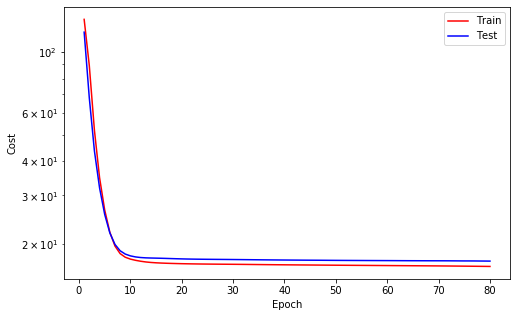



Epoch    81
Train_cost  = 16.5307 | Test_cost  = 17.2901 | 




Epoch    82
Train_cost  = 16.5199 | Test_cost  = 17.2800 | 




Epoch    83
Train_cost  = 16.5095 | Test_cost  = 17.2617 | 




Epoch    84
Train_cost  = 16.4921 | Test_cost  = 17.2269 | 




Epoch    85
Train_cost  = 16.4606 | Test_cost  = 17.2207 | 




Epoch    86
Train_cost  = 16.4521 | Test_cost  = 17.2236 | 
==> EarlyStop patience =  1 | Best test_cost: 17.2207




Epoch    87
Train_cost  = 16.4329 | Test_cost  = 17.1940 | 




Epoch    88
Train_cost  = 16.4037 | Test_cost  = 17.1690 | 




Epoch    89
Train_cost  = 16.3618 | Test_cost  = 17.1601 | 




Epoch    90
Train_cost  = 16.3115 | Test_cost  = 17.1021 | 




Epoch    91
Train_cost  = 16.2692 | Test_cost  = 17.0028 | 




Epoch    92
Train_cost  = 16.1961 | Test_cost  = 16.9074 | 




Epoch    93
Train_cost  = 16.1181 | Test_cost  = 16.8367 | 




Epoch    94
Train_cost  = 16.0433 | Test_cost  = 16.7649 | 




Epoch    95
Train_cost  = 15.9819 | Test_cost  = 16.6744 | 




Epoch    96
Train_cost  = 15.9055 | Test_cost  = 16.5690 | 




Epoch    97
Train_cost  = 15.8083 | Test_cost  = 16.5394 | 




Epoch    98
Train_cost  = 15.6754 | Test_cost  = 16.4574 | 




Epoch    99
Train_cost  = 15.9694 | Test_cost  = 16.2165 | 




Epoch   100
Train_cost  = 15.3425 | Test_cost  = 16.1774 | 


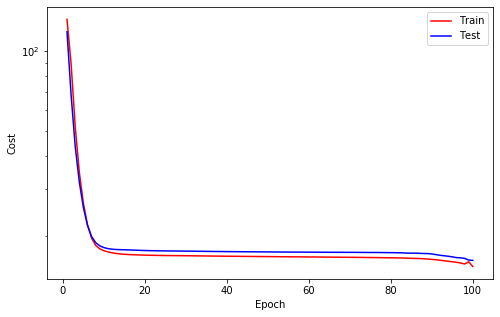



Epoch   101
Train_cost  = 15.1992 | Test_cost  = 15.7332 | 




Epoch   102
Train_cost  = 14.6860 | Test_cost  = 14.3506 | 




Epoch   103
Train_cost  = 13.1703 | Test_cost  = 12.9181 | 




Epoch   104
Train_cost  = 12.1546 | Test_cost  = 11.0187 | 




Epoch   105
Train_cost  = 10.7184 | Test_cost  = 9.9549 | 




Epoch   106
Train_cost  = 9.7827 | Test_cost  = 8.8415 | 




Epoch   107
Train_cost  = 9.1083 | Test_cost  = 8.2050 | 




Epoch   108
Train_cost  = 8.4414 | Test_cost  = 7.3733 | 




Epoch   109
Train_cost  = 7.8577 | Test_cost  = 7.0127 | 




Epoch   110
Train_cost  = 7.5446 | Test_cost  = 6.6575 | 




Epoch   111
Train_cost  = 7.2846 | Test_cost  = 6.4282 | 




Epoch   112
Train_cost  = 7.1578 | Test_cost  = 6.2671 | 




Epoch   113
Train_cost  = 7.0698 | Test_cost  = 6.2344 | 




Epoch   114
Train_cost  = 6.9776 | Test_cost  = 6.2117 | 




Epoch   115
Train_cost  = 6.9241 | Test_cost  = 6.1188 | 




Epoch   116
Train_cost  = 6.8732 | Test_cost  = 5.9368 | 




Epoch   117
Train_cost  = 6.8223 | Test_cost  = 5.7677 | 




Epoch   118
Train_cost  = 6.6934 | Test_cost  = 5.7389 | 




Epoch   119
Train_cost  = 6.6247 | Test_cost  = 5.7208 | 




Epoch   120
Train_cost  = 6.5682 | Test_cost  = 5.6816 | 


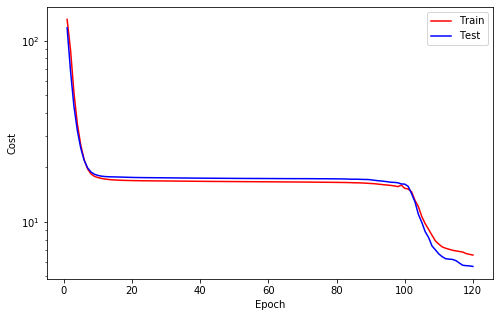



Epoch   121
Train_cost  = 6.5178 | Test_cost  = 5.6156 | 




Epoch   122
Train_cost  = 6.4685 | Test_cost  = 5.5529 | 




Epoch   123
Train_cost  = 6.4296 | Test_cost  = 5.5068 | 




Epoch   124
Train_cost  = 6.3994 | Test_cost  = 5.4607 | 




Epoch   125
Train_cost  = 6.3703 | Test_cost  = 5.4243 | 




Epoch   126
Train_cost  = 6.3506 | Test_cost  = 5.3881 | 




Epoch   127
Train_cost  = 6.3253 | Test_cost  = 5.3596 | 




Epoch   128
Train_cost  = 6.3052 | Test_cost  = 5.3342 | 




Epoch   129
Train_cost  = 6.2884 | Test_cost  = 5.3132 | 




Epoch   130
Train_cost  = 6.2669 | Test_cost  = 5.2931 | 




Epoch   131
Train_cost  = 6.2563 | Test_cost  = 5.2775 | 




Epoch   132
Train_cost  = 6.2326 | Test_cost  = 5.2584 | 




Epoch   133
Train_cost  = 6.2257 | Test_cost  = 5.2468 | 




Epoch   134
Train_cost  = 6.2040 | Test_cost  = 5.2258 | 




Epoch   135
Train_cost  = 6.2039 | Test_cost  = 5.2202 | 




Epoch   136
Train_cost  = 6.1959 | Test_cost  = 5.2031 | 




Epoch   137
Train_cost  = 6.1983 | Test_cost  = 5.2227 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2031




Epoch   138
Train_cost  = 6.1991 | Test_cost  = 5.2568 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2031




Epoch   139
Train_cost  = 6.2227 | Test_cost  = 5.3033 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2031




Epoch   140
Train_cost  = 6.1961 | Test_cost  = 5.4274 | 


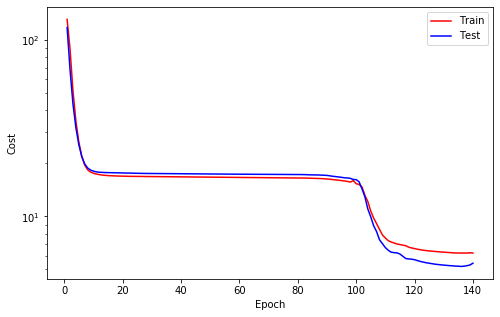

==> EarlyStop patience =  4 | Best test_cost: 5.2031




Epoch   141
Train_cost  = 6.2182 | Test_cost  = 5.4985 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2031
==> Execute Early Stopping at epoch: 141 | Best test_cost: 5.2031
==> Best model is saved at model/lstm


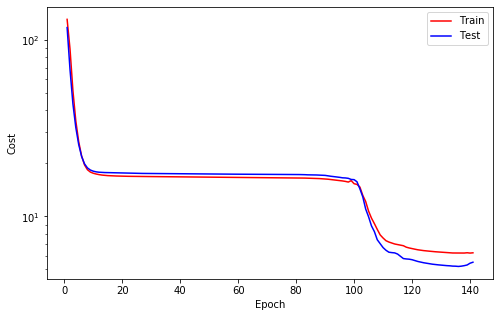

In [38]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
        
    # Logging
    callback.log(train_cost, test_cost)
    
    #Checkpoint
    callback.save_checkpoint()
    
    #Runtime Plotting
    callback.cost_runtime_plotting()
    
    #Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [39]:
from luwiji.rnn import illustration

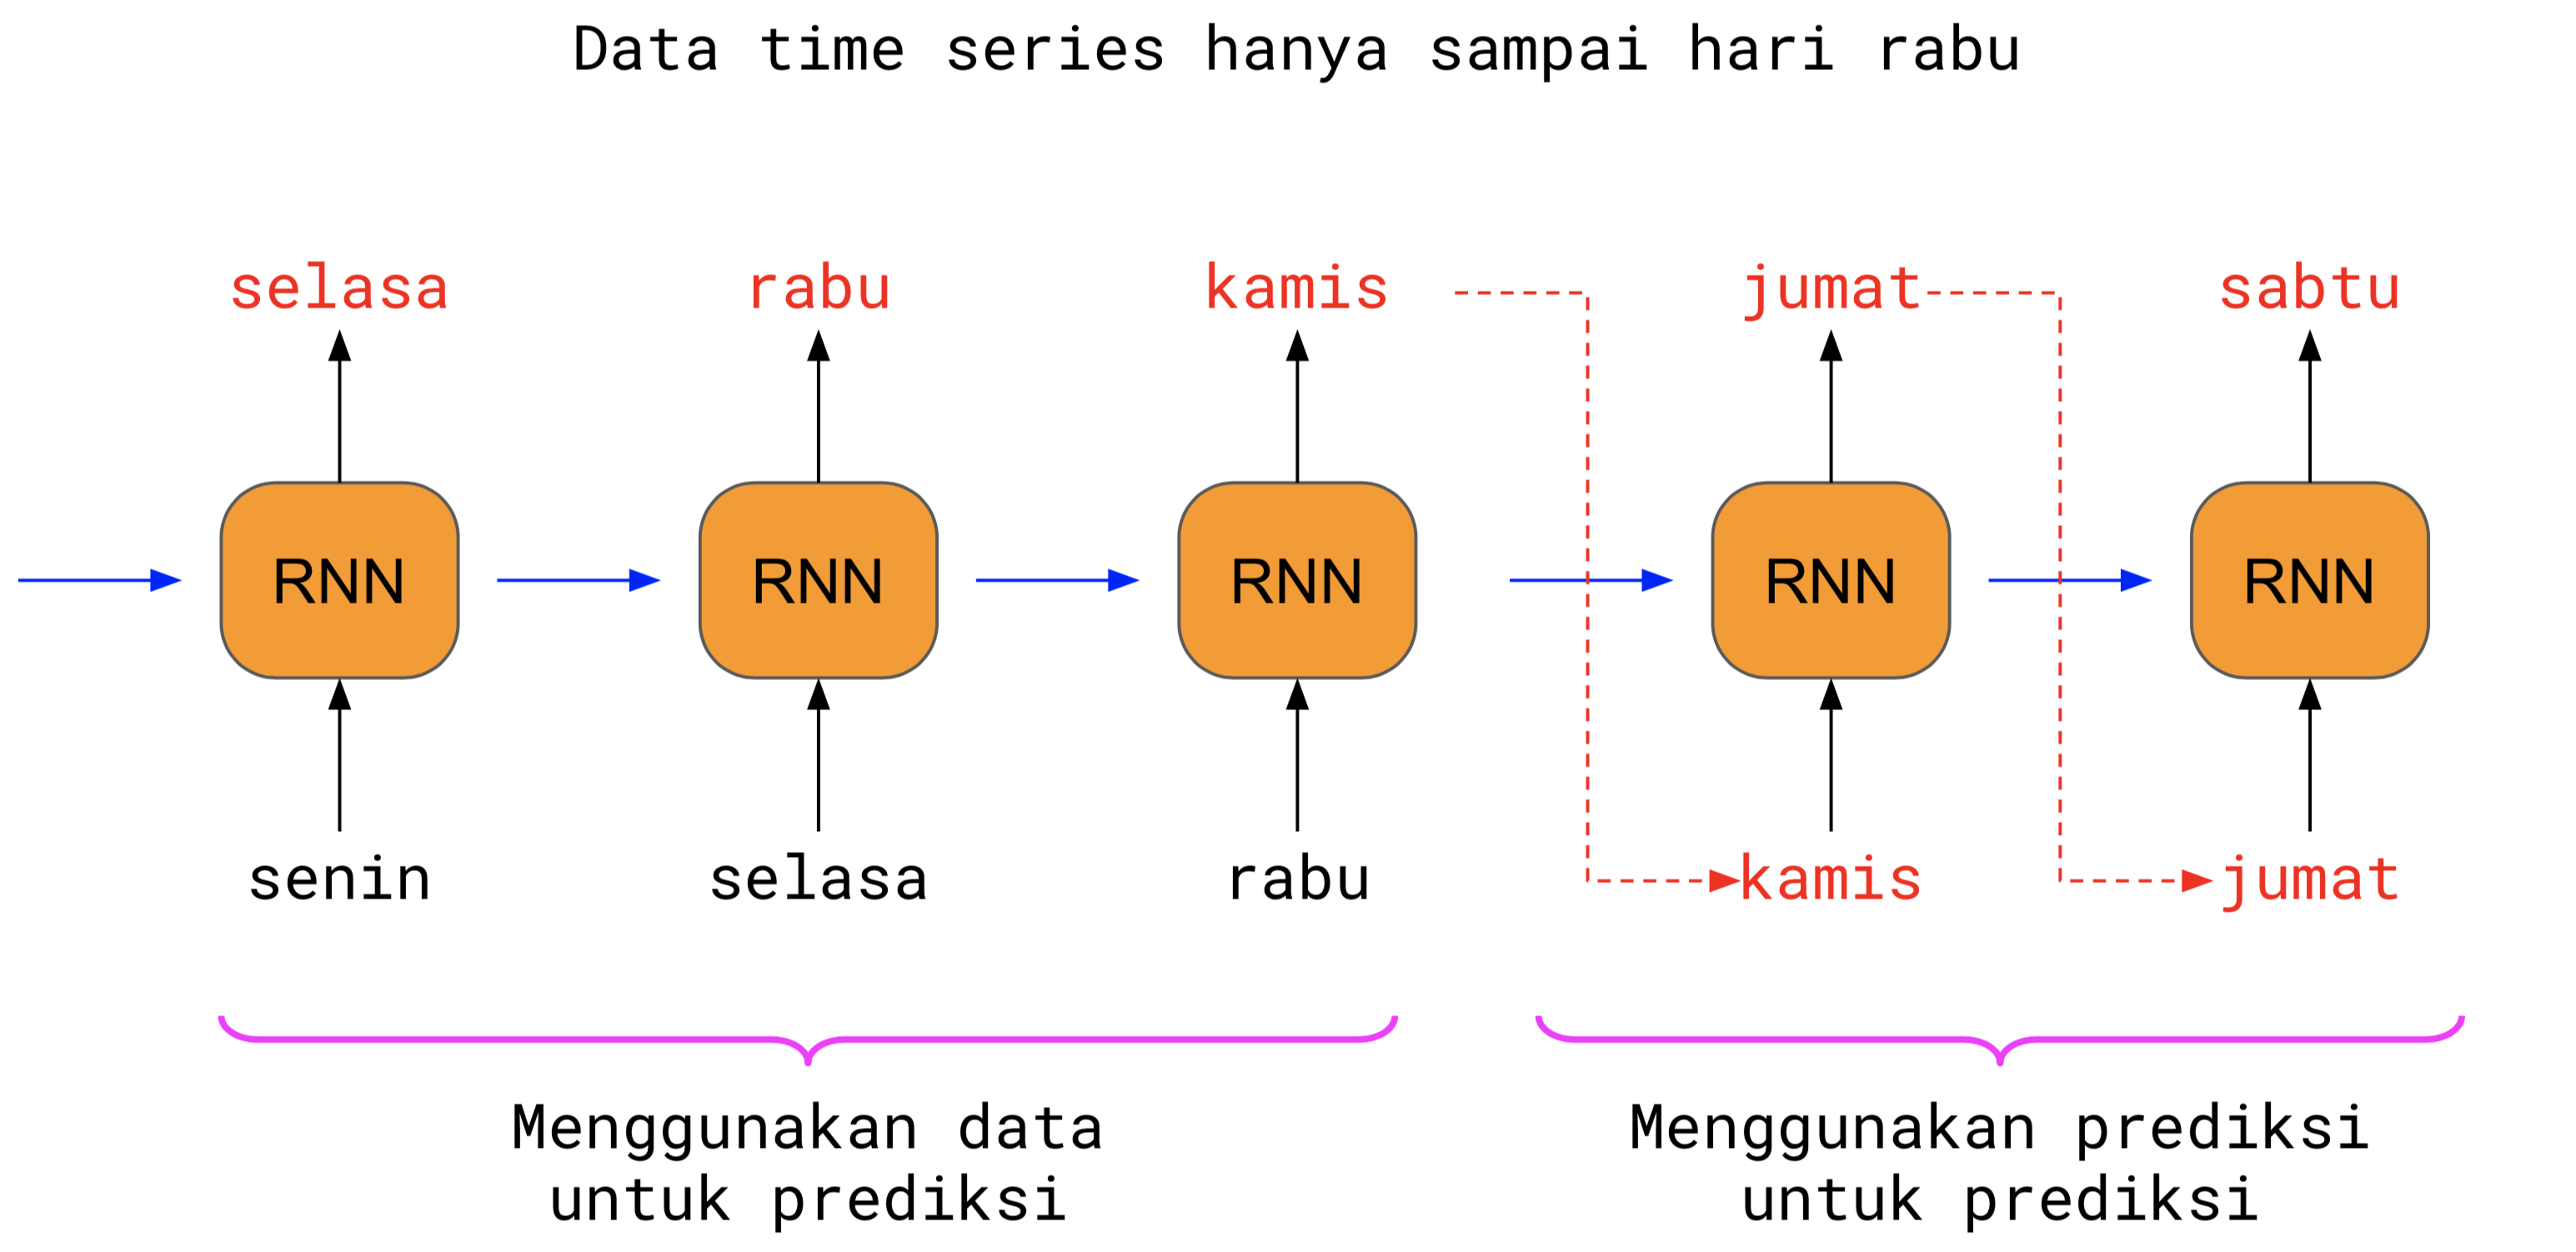

In [40]:
illustration.forecast

In [41]:
from utils import data4pred, pred4pred

In [42]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

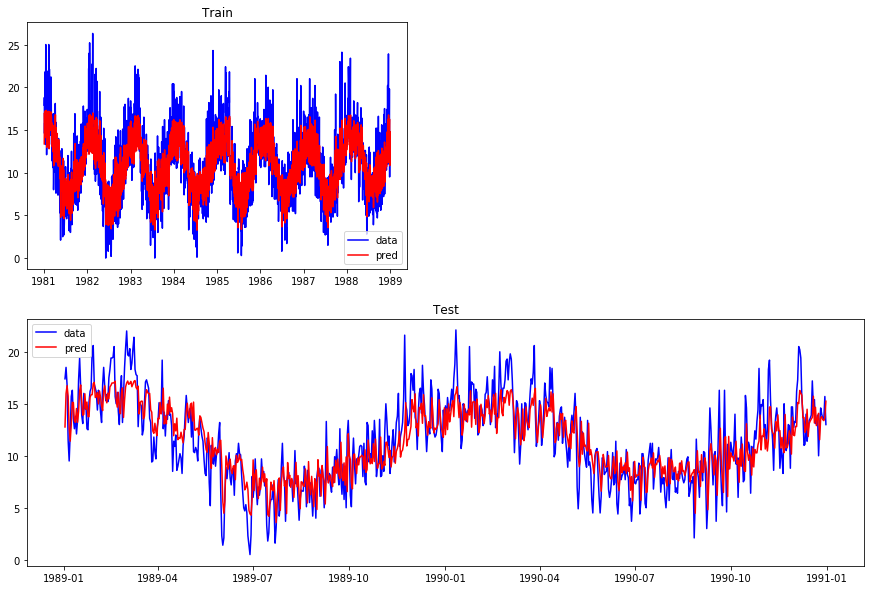

In [43]:
# Data 4 Pred
plt.figure(figsize=(15,10))

plt.subplot(221)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

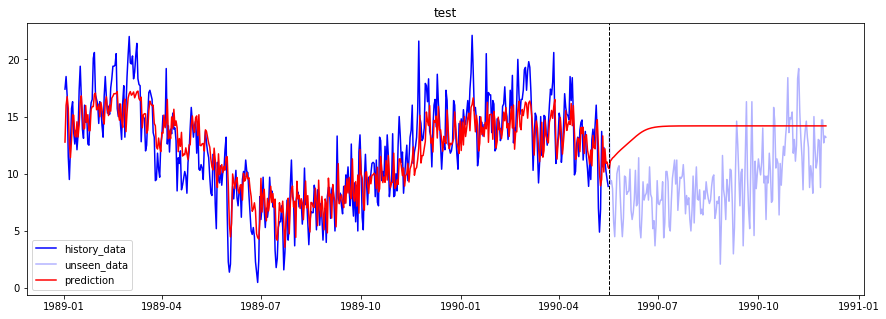

In [44]:
# Pred 4 Pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")